# Titanic：Achieve 84% Accuracy()

載入相關的套件

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import statistics as stat
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import IPython
from IPython import display
from scipy import stats
import math
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

讀取資料，將官方給的Train、Test dataset合併，方便日後的Feature Engineer。

In [2]:
# Read Data
train = pd.read_csv('D:/kaggle/Titanic/train.csv', index_col='PassengerId')
test = pd.read_csv('D:/kaggle/Titanic/test.csv', index_col='PassengerId')
y = train.Survived
train = train.drop('Survived', axis=1)
df_all = pd.concat([train, test], axis=0, sort=True)
print(df_all.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 10 columns):
Age         1046 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
Fare        1308 non-null float64
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Ticket      1309 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 112.5+ KB
None


# Data Cleaning

## EDA

在進行Data Cleaning之前，先進行EDA。

看一下Missing Data。從下圖得知共有4個Columns包含Missing Data。

Cabin       1014
Age          263
Embarked       2
Fare           1
dtype: int64


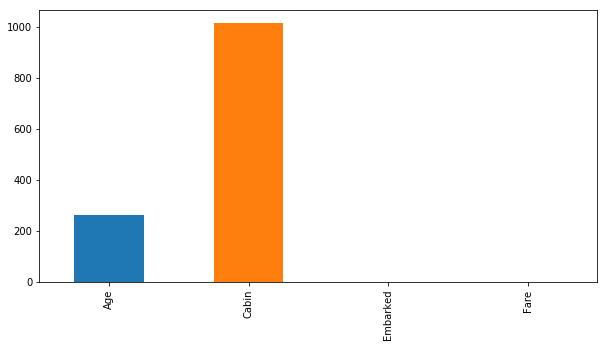

In [3]:
na_col = df_all.isnull().sum()
na_col = na_col[na_col > 0]
plt.subplots(figsize=(10, 5))
na_col.plot(kind='bar')
print(na_col.sort_values(ascending=False))

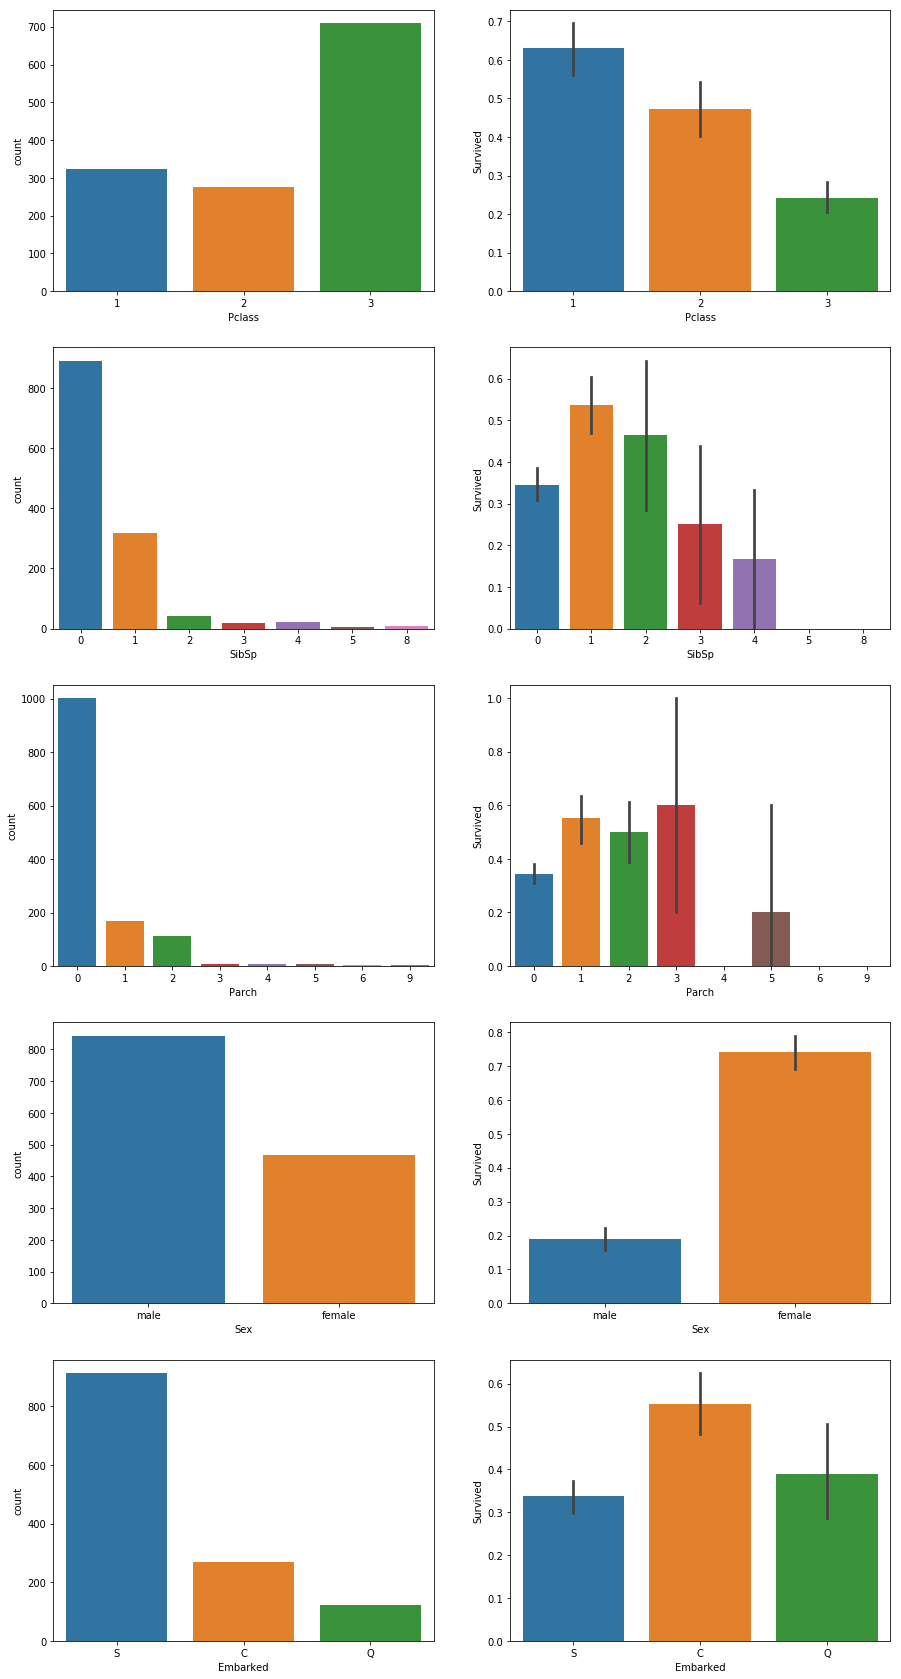

In [4]:
fig, axis = plt.subplots(5,2,figsize=(15,30))

sns.countplot(df_all['Pclass'], ax = axis[0][0])
sns.barplot(x = 'Pclass', y = y, data = df_all, ax = axis[0][1])
sns.countplot(df_all['SibSp'], ax = axis[1][0])
sns.barplot(x = 'SibSp', y = y, data = df_all, ax = axis[1][1])
sns.countplot(df_all['Parch'], ax = axis[2][0])
sns.barplot(x = 'Parch', y = y, data = df_all, ax = axis[2][1])
sns.countplot(df_all['Sex'], ax = axis[3][0])
sns.barplot(x = 'Sex', y = y, data = df_all, ax = axis[3][1])
sns.countplot(df_all['Embarked'], ax = axis[4][0])
sns.barplot(x = 'Embarked', y = y, data = df_all, ax = axis[4][1])

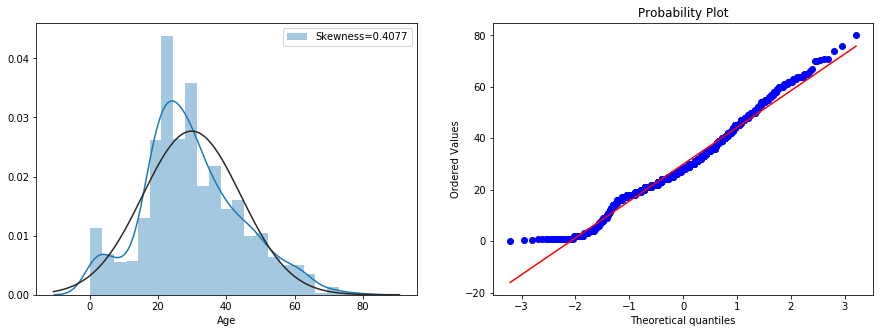

In [5]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df_all.Age.dropna() , fit=stats.norm, label='Skewness=%.4f'%df_all.Age.skew());
plt.legend()
plt.subplot(1,2,2)
_=stats.probplot(df_all.Age.dropna(), plot=plt)

可以看到，'Fare'有Skewness的問題，會嘗試用log1p處理

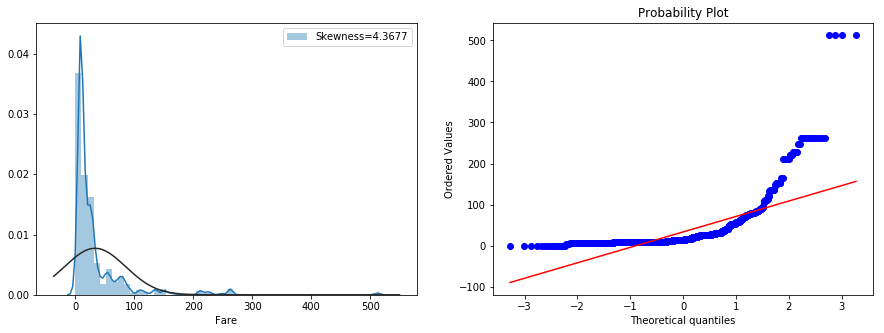

In [6]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df_all.Fare.dropna() , fit=stats.norm, label='Skewness=%.4f'%df_all.Fare.skew());
plt.legend()
plt.subplot(1,2,2)
_=stats.probplot(df_all.Fare.dropna(), plot=plt)

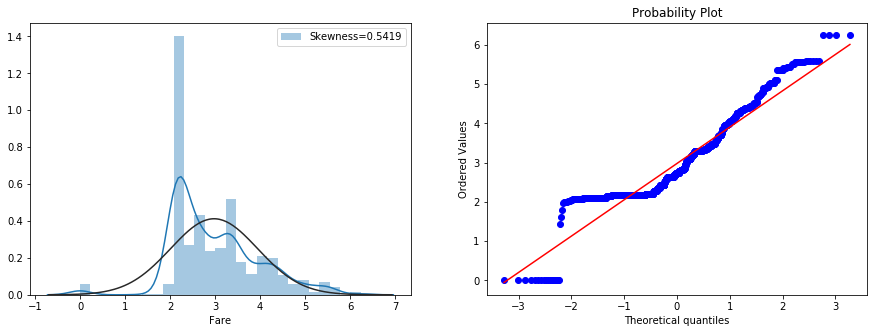

In [7]:
# 消除Skewness
df_all['Fare'] = np.log1p(df_all['Fare'])
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(df_all.Fare.dropna() , fit=stats.norm, label='Skewness=%.4f'%df_all.Fare.skew());
plt.legend()
plt.subplot(1,2,2)
_=stats.probplot(df_all.Fare.dropna(), plot=plt)

## Missing Data & Outlier

根據這一個月建模經歷以及其他Kaggler建議Missing Data與Outlier是Data Cleaning最重要的一部分。尤其是Outlier，如果要將分數往上刷一定要去除!!
首先，我先處理Outlier的部分。我將Training Data中的Outlier去除以免影響預測模型

In [8]:
columns = train.dtypes[train.dtypes != object].index
outlier_indices = []
for col in train[columns]:
    Q1 = np.percentile(train[col], 25)
    Q3 = np.percentile(train[col], 75)
    IQR = Q3 - Q1
    outlier_col_list = train[(train[col] < Q1 - 1.5 * IQR) |
                             (train[col] > Q3 + 1.5 * IQR)].index
    outlier_indices.extend(outlier_col_list)
outlier_indices = Counter(outlier_indices)
multiple_outliers = list(k for k, v in outlier_indices.items() if v > 2)
# Drop outliers
df_all = df_all.drop(multiple_outliers, axis=0)
y = y.drop(multiple_outliers, axis=0)

由於Column 'Cabin'包含太多缺失值(78%)，因此我直接去除!

In [9]:
df_all = df_all.drop(['Cabin'], axis=1)

Columns 'Embarked' and 'Fare'缺失值並不多，分別填入眾數以及中位數。

In [10]:
df_all.Fare.fillna(stat.median(df_all.Fare), inplace=True)
df_all.Embarked.fillna(stat.mode(df_all.Embarked), inplace=True)

'Age'包含256筆缺失值，我試過用Lasso Regression來預測缺失值，但效果並不好。最後我用中位數代替(中位數非常的好用，因為可以有效的減少Skeness)

In [11]:
df_all['Age'].fillna(df_all['Age'].median(), inplace=True)

In [12]:
# overview
df_all.info()
df_all.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1299 entries, 1 to 1309
Data columns (total 9 columns):
Age         1299 non-null float64
Embarked    1299 non-null object
Fare        1299 non-null float64
Name        1299 non-null object
Parch       1299 non-null int64
Pclass      1299 non-null int64
Sex         1299 non-null object
SibSp       1299 non-null int64
Ticket      1299 non-null object
dtypes: float64(2), int64(3), object(4)
memory usage: 101.5+ KB


,Age,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Ticket
PassengerId,,,,,,,,,
1,22.0,S,2.110213,"Braund, Mr. Owen Harris",0,3,male,1,A/5 21171
2,38.0,C,4.280593,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,PC 17599
3,26.0,S,2.188856,"Heikkinen, Miss. Laina",0,3,female,0,STON/O2. 3101282
4,35.0,S,3.990834,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,113803
5,35.0,S,2.202765,"Allen, Mr. William Henry",0,3,male,0,373450


# Feature Engineer

原始資料可以由人工推導出其他有用的資訊(刷分關鍵!!)接下來我換增加一些新的欄位。

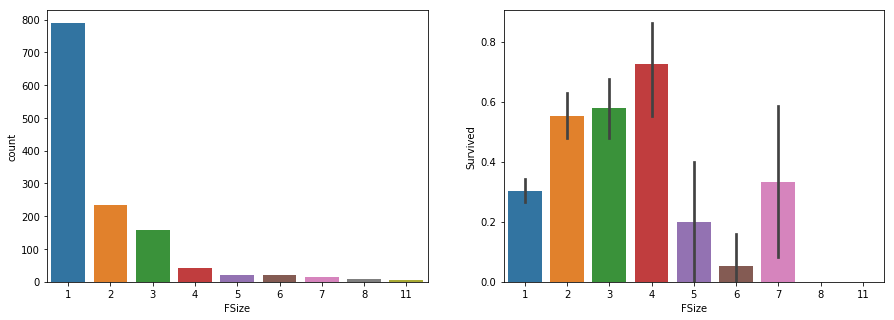

In [13]:
# Family Size(從'Parch' and 'Sibsp'其實可以知道家庭大小)
df_all['FSize'] = df_all['Parch'] + df_all['SibSp'] + 1 # +1是因為如果沒有家人自己本身

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(df_all['FSize']);
plt.subplot(1,2,2)
sns.barplot(x='FSize', y=y, data=df_all)

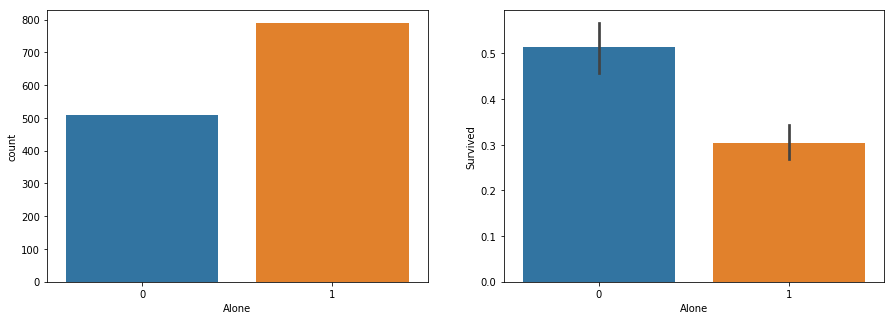

In [14]:
# Is alone?
df_all['Alone'] = df_all['FSize'].map(lambda s: 1 if s <= 1 else 0)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(df_all['Alone']);
plt.subplot(1,2,2)
sns.barplot(x='Alone', y=y, data=df_all)

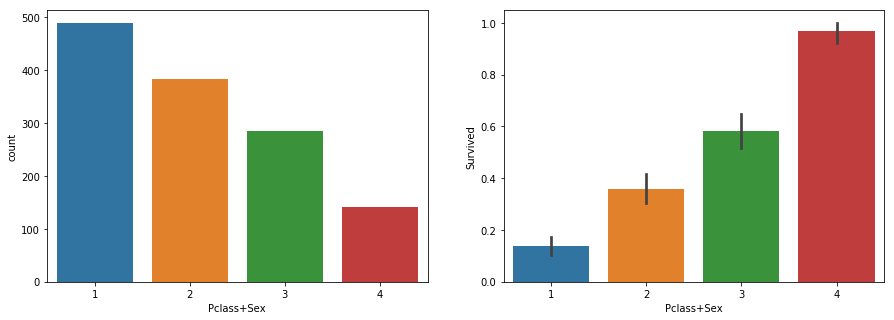

In [15]:
# Sex & Pclass
df_all['Pclass'].replace({3: 1, 1: 3}, inplace=True)
df_all['Pclass+Sex'] = df_all['Pclass'] + df_all['Sex'].map({"male": 0, "female": 1})
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(df_all['Pclass+Sex']);
plt.subplot(1,2,2)
sns.barplot(x='Pclass+Sex', y=y, data=df_all)

有人只使用'Name'就將成功率達到0.82左右，意味者Name欄位的重要性。學者也提出：It's important to note, more predictor variables do not make a better model, but the right variables.

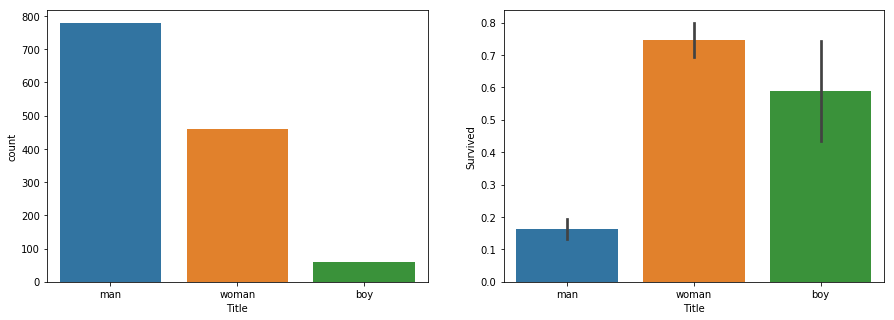

In [16]:
# New Name
df_all['Title'] = df_all['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
df_all["Title"] = df_all["Title"].replace(['Capt', 'Don', 'Major', 'Col', 'Rev', 'Dr', 'Sir', 'Mr', 'Jonkheer'], 'man')
df_all["Title"] = df_all["Title"].replace(['the Countess', 'Dona', 'Mme', 'Mlle', 'Ms', 'Miss', 'Lady', 'Mrs'], 'woman')
df_all["Title"] = df_all["Title"].replace(['Master'], 'boy')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(df_all['Title']);
plt.subplot(1,2,2)
sns.barplot(x='Title', y=y, data=df_all)

In [17]:
# 可以發現，當女性和小孩姓氏相同(同一個家庭)，結局幾乎不是全罹難或是全部存活
df_all['SureName'] = df_all['Name'].str.split(", ", expand=True)[0]
df_all["SureName"] = df_all["SureName"].replace(df_all[df_all['Title'] == 'man'].SureName, 'noGroup')
df_all["SureName"] = df_all["SureName"].replace([item for item, count in Counter(df_all["SureName"]).items() if count <= 1]
                                              , 'noGroup')
group = df_all.groupby(['SureName', y])
group.size()

SureName       Survived
Abbott         1.0           1
Aks            1.0           1
Allison        0.0           2
               1.0           1
Andersson      0.0           6
               1.0           1
Asplund        0.0           1
               1.0           3
Baclini        1.0           4
Barbara        0.0           2
Becker         1.0           2
Bonnell        1.0           1
Boulos         0.0           2
Bourke         0.0           2
Brown          1.0           3
Burns          1.0           1
Cacic          0.0           1
Caldwell       1.0           2
Carr           1.0           1
Carter         0.0           1
               1.0           3
Christy        1.0           1
Collyer        1.0           2
Compton        1.0           1
Connolly       1.0           1
Coutts         1.0           2
Crosby         1.0           1
Danbom         0.0           1
Davies         1.0           1
Dean           1.0           1
                          ... 
Newell         

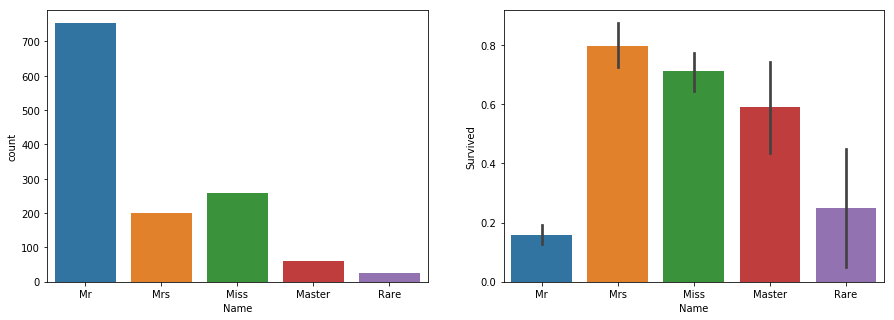

In [18]:
# 再將Title分成細一點
df_all['Name'] = df_all['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
df_all["Name"] = df_all["Name"].replace(['Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare')
df_all["Name"] = df_all["Name"].replace(['the Countess', 'Ms', 'Mme'], 'Mrs')
df_all["Name"] = df_all["Name"].replace(['Mlle', 'Lady', 'Mme'], 'Miss')
df_all["Name"] = df_all["Name"].replace(['Sir'], 'Mr')

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(df_all['Name']);
plt.subplot(1,2,2)
sns.barplot(x='Name', y=y, data=df_all)

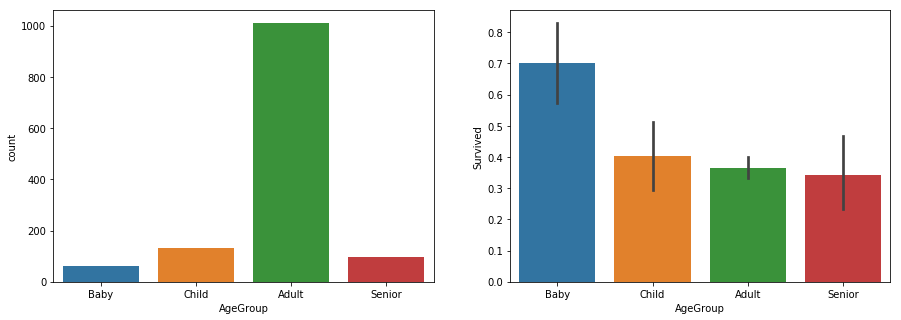

In [19]:
# Age
bin = [0, 6, 18, 50, 80]
label = ['Baby', 'Child', 'Adult', 'Senior']
df_all['AgeGroup'] = pd.cut(df_all['Age'], bins=bin, labels=label)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(df_all['AgeGroup']);
plt.subplot(1,2,2)
sns.barplot(x='AgeGroup', y=y, data=df_all.loc[:891])

In [20]:
# Ticket:看似是隨機變數，我直接將他移除
df_all = df_all.drop('Ticket', axis=1)

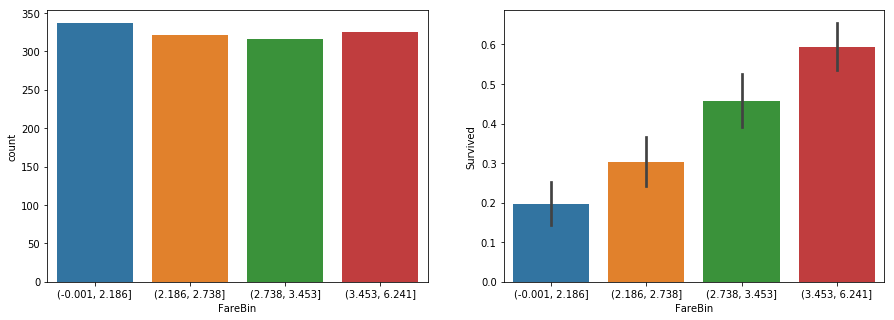

In [21]:
# Fare:區分成4等分，將個數盡量保持一致
df_all['FareBin'] = pd.qcut(df_all['Fare'], 4)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(df_all['FareBin']);
plt.subplot(1,2,2)
sns.barplot(x='FareBin', y=y, data=df_all.loc[:891])

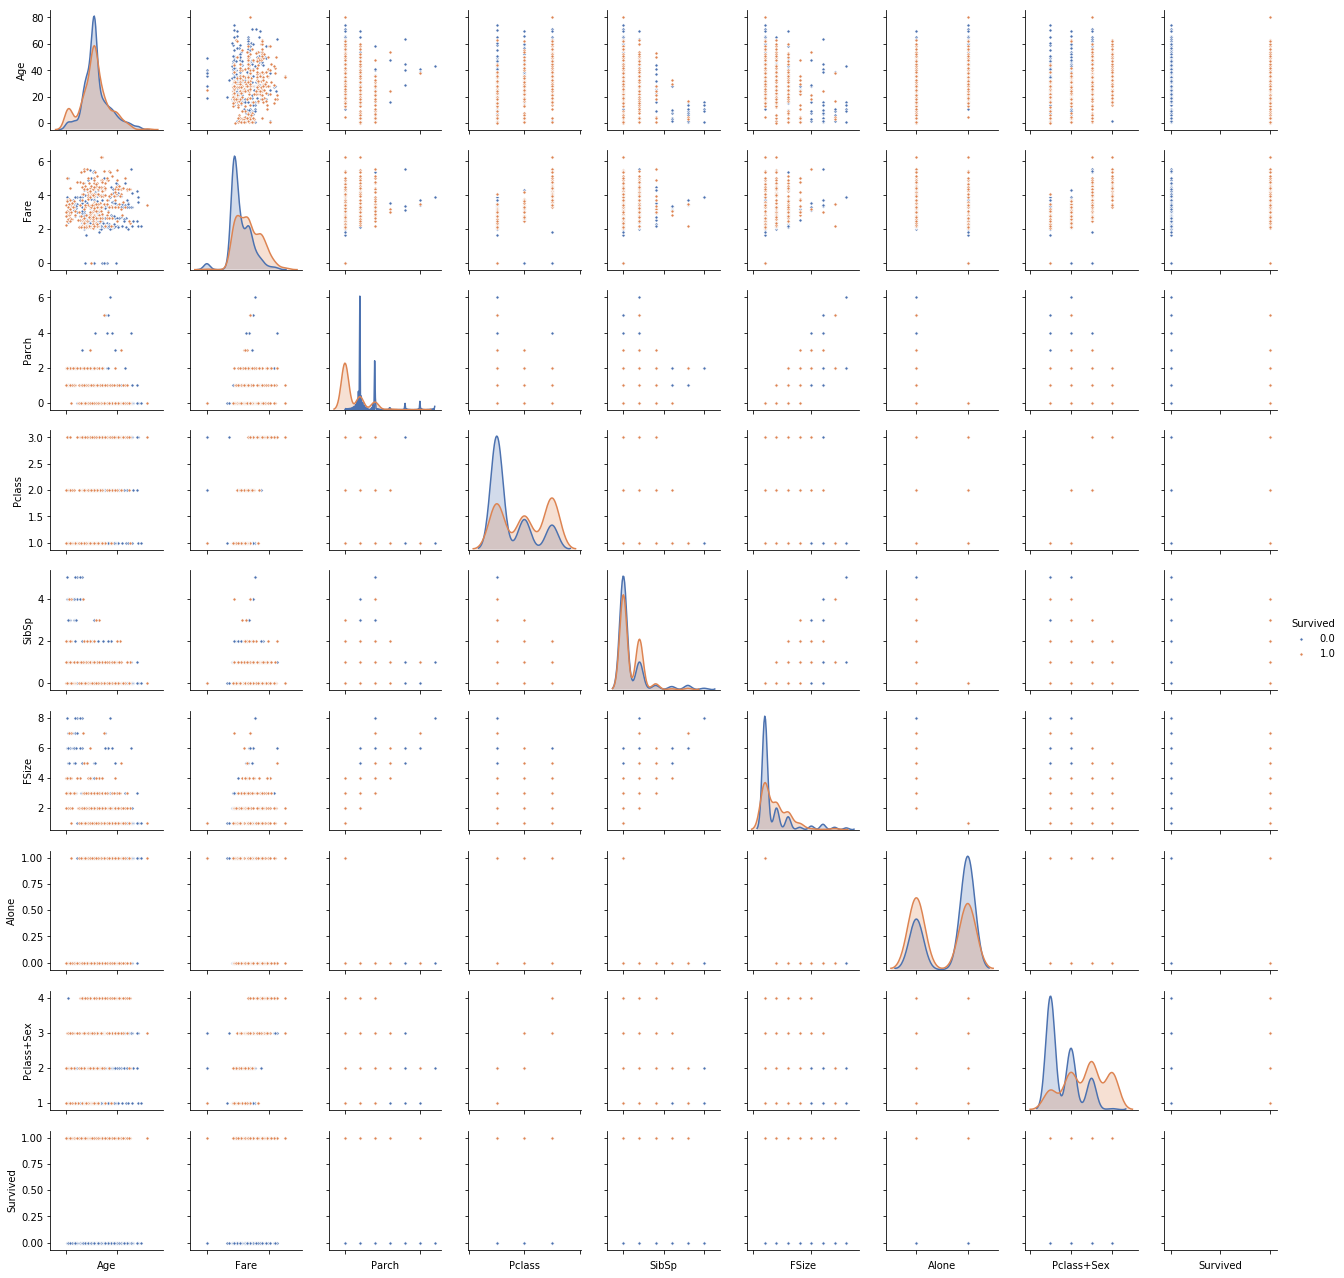

In [22]:
df_all['Survived'] = y
g = sns.pairplot(df_all, hue='Survived',palette = 'deep', size=2, diag_kind = 'kde'
                 , diag_kws=dict(shade=True), plot_kws=dict(s=10) )
g.set(xticklabels=[])

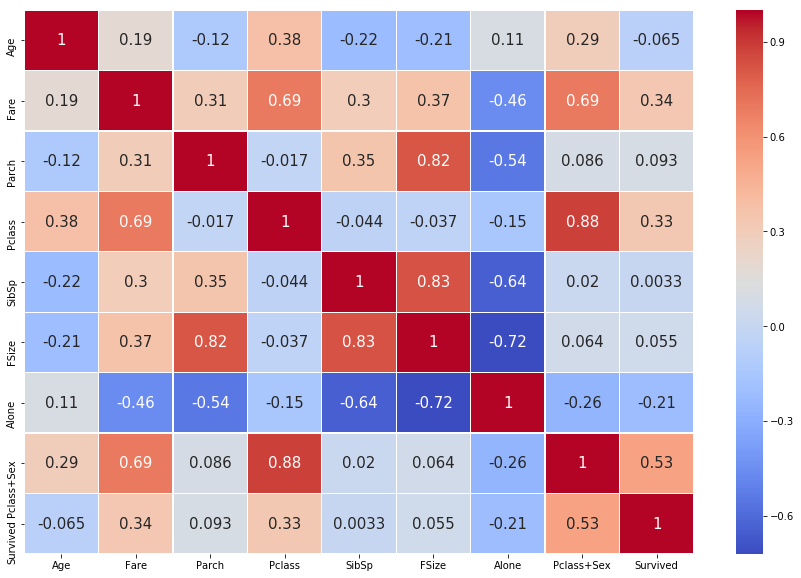

In [23]:
# Correlation
cor = df_all.corr()
plt.figure(figsize=(15,10))
sns.heatmap(cor, cmap = 'coolwarm', annot=True, annot_kws={'fontsize':15 }, cbar_kws={'shrink':1 }
            , linewidths=0.1, vmax=1.0, linecolor='white')

In [24]:
# one-hot encoding 
cols = []
cols = df_all.dtypes[df_all.dtypes == object].index
cols = cols.append(df_all.dtypes[df_all.dtypes == 'category'].index)
for col in cols:
    df_all = pd.get_dummies(df_all, columns=[col], prefix=col)

df_all.info()    
df_all.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1299 entries, 1 to 1309
Columns: 129 entries, Age to FareBin_(3.453, 6.241]
dtypes: float64(3), int64(6), uint8(120)
memory usage: 293.7 KB


,Age,Fare,Parch,Pclass,SibSp,FSize,Alone,Pclass+Sex,Survived,Embarked_C,...,SureName_noGroup,SureName_van Billiard,AgeGroup_Baby,AgeGroup_Child,AgeGroup_Adult,AgeGroup_Senior,"FareBin_(-0.001, 2.186]","FareBin_(2.186, 2.738]","FareBin_(2.738, 3.453]","FareBin_(3.453, 6.241]"
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,22.0,2.110213,0,1,1,2,0,1,0.0,0,...,1,0,0,0,1,0,1,0,0,0
2,38.0,4.280593,0,3,1,2,0,4,1.0,1,...,1,0,0,0,1,0,0,0,0,1
3,26.0,2.188856,0,1,0,1,1,2,1.0,0,...,1,0,0,0,1,0,0,1,0,0
4,35.0,3.990834,0,3,1,2,0,4,1.0,0,...,1,0,0,0,1,0,0,0,0,1
5,35.0,2.202765,0,1,0,1,1,1,0.0,0,...,1,0,0,0,1,0,0,1,0,0


# Model Data

目前資料前處理到一個段落，接著就是模型建置

## Split Data

In [26]:
X = df_all.loc[:891].drop('Survived', axis=1)
y = df_all['Survived'].loc[:891]
test = df_all.loc[892:].drop('Survived', axis=1)

載入需要用到的model，不得不說Sklearn真的很方便!!

In [27]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier\
    , GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, BaggingClassifier
from sklearn import model_selection
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV, PassiveAggressiveClassifier, RidgeClassifierCV, SGDClassifier, Perceptron
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, cross_validate, learning_curve

In [28]:
# 載入分類相關演算法
classifiers = []
# Ensemble
classifiers.append(['RandomForest', RandomForestClassifier()])
classifiers.append(['AdaBoost', AdaBoostClassifier()])
classifiers.append(['GradientBoosting', GradientBoostingClassifier()])
classifiers.append(['ExtraTrees_Ensemble', ExtraTreesClassifier()])
classifiers.append(['Bagging', BaggingClassifier()])
# Gaussian Processes
classifiers.append(['GaussianProcess', GaussianProcessClassifier()])
# Tree
classifiers.append(['DecisionTree', DecisionTreeClassifier()])
classifiers.append(['ExtraTree_Tree', ExtraTreeClassifier()])
# GLM
classifiers.append(['Logistic', LogisticRegressionCV()])
classifiers.append(['PassiveAggressive', PassiveAggressiveClassifier()])
classifiers.append(['Ridge', RidgeClassifierCV()])
classifiers.append(['SGD', SGDClassifier()])
classifiers.append(['Perceptron', Perceptron()])
# Navies Bayes
classifiers.append(['BernoulliNB', BernoulliNB()])
classifiers.append(['GaussianNB', GaussianNB()])
# KNN
classifiers.append(['KNN', KNeighborsClassifier()])
# SVM
classifiers.append(['SVC', SVC(probability=True)])
classifiers.append(['NuSVC', NuSVC(probability=True)])
classifiers.append(['LinearSVC', LinearSVC()])
# Discriminant Analysis
classifiers.append(['LinearDiscriminant', LinearDiscriminantAnalysis()])
classifiers.append(['QuadraticDiscriminant', QuadraticDiscriminantAnalysis()])
# Rest
classifiers.append(['MLP', MLPClassifier(random_state=2)])

In [29]:
# Generate Comparing Table
MLA_compare = pd.DataFrame(columns=['Name', 'Train Accuracy Mean', 'Test Accuracy Mean', 'Time'])
row_index = 0
cv_split = model_selection.ShuffleSplit(n_splits=10, test_size=0.3, train_size=0.6, random_state=7)
for name, model in classifiers:
    cv_result = cross_validate(model, X, y, cv=cv_split)
    MLA_compare.loc[row_index, 'Name'] = name
    MLA_compare.loc[row_index, 'Train Accuracy Mean'] = cv_result['train_score'].mean()
    MLA_compare.loc[row_index, 'Test Accuracy Mean'] = cv_result['test_score'].mean()
    MLA_compare.loc[row_index, 'Time'] = cv_result['fit_time'].mean()
    row_index += 1

MLA_compare.sort_values(by = ['Test Accuracy Mean'], ascending = False, inplace=True)
MLA_compare

,Name,Train Accuracy Mean,Test Accuracy Mean,Time
10,Ridge,0.859659,0.841509,0.0293826
19,LinearDiscriminant,0.859848,0.841132,0.0376951
21,MLP,0.880871,0.83283,0.940602
2,GradientBoosting,0.896402,0.83283,0.127404
8,Logistic,0.852083,0.826415,0.952951
1,AdaBoost,0.873864,0.816604,0.0891756
17,NuSVC,0.824811,0.813208,0.235043
4,Bagging,0.972538,0.810566,0.0271851
18,LinearSVC,0.829545,0.810189,0.0413371
16,SVC,0.821402,0.808302,0.224882


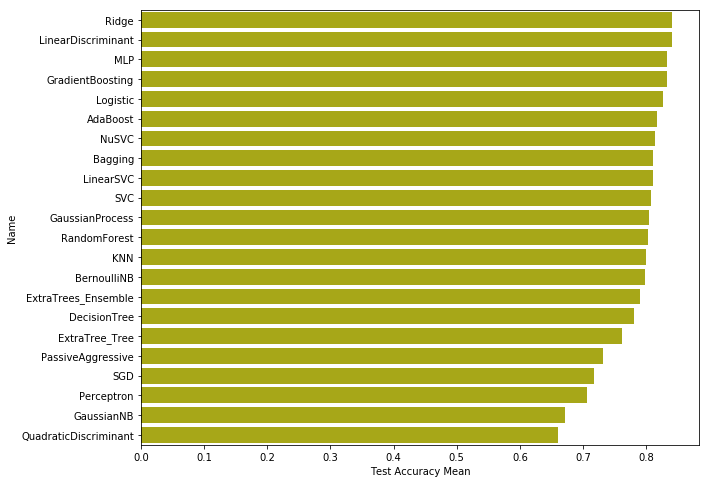

In [30]:
plt.figure(figsize=(10,8))
sns.barplot(x='Test Accuracy Mean', y='Name', data=MLA_compare, color='y')

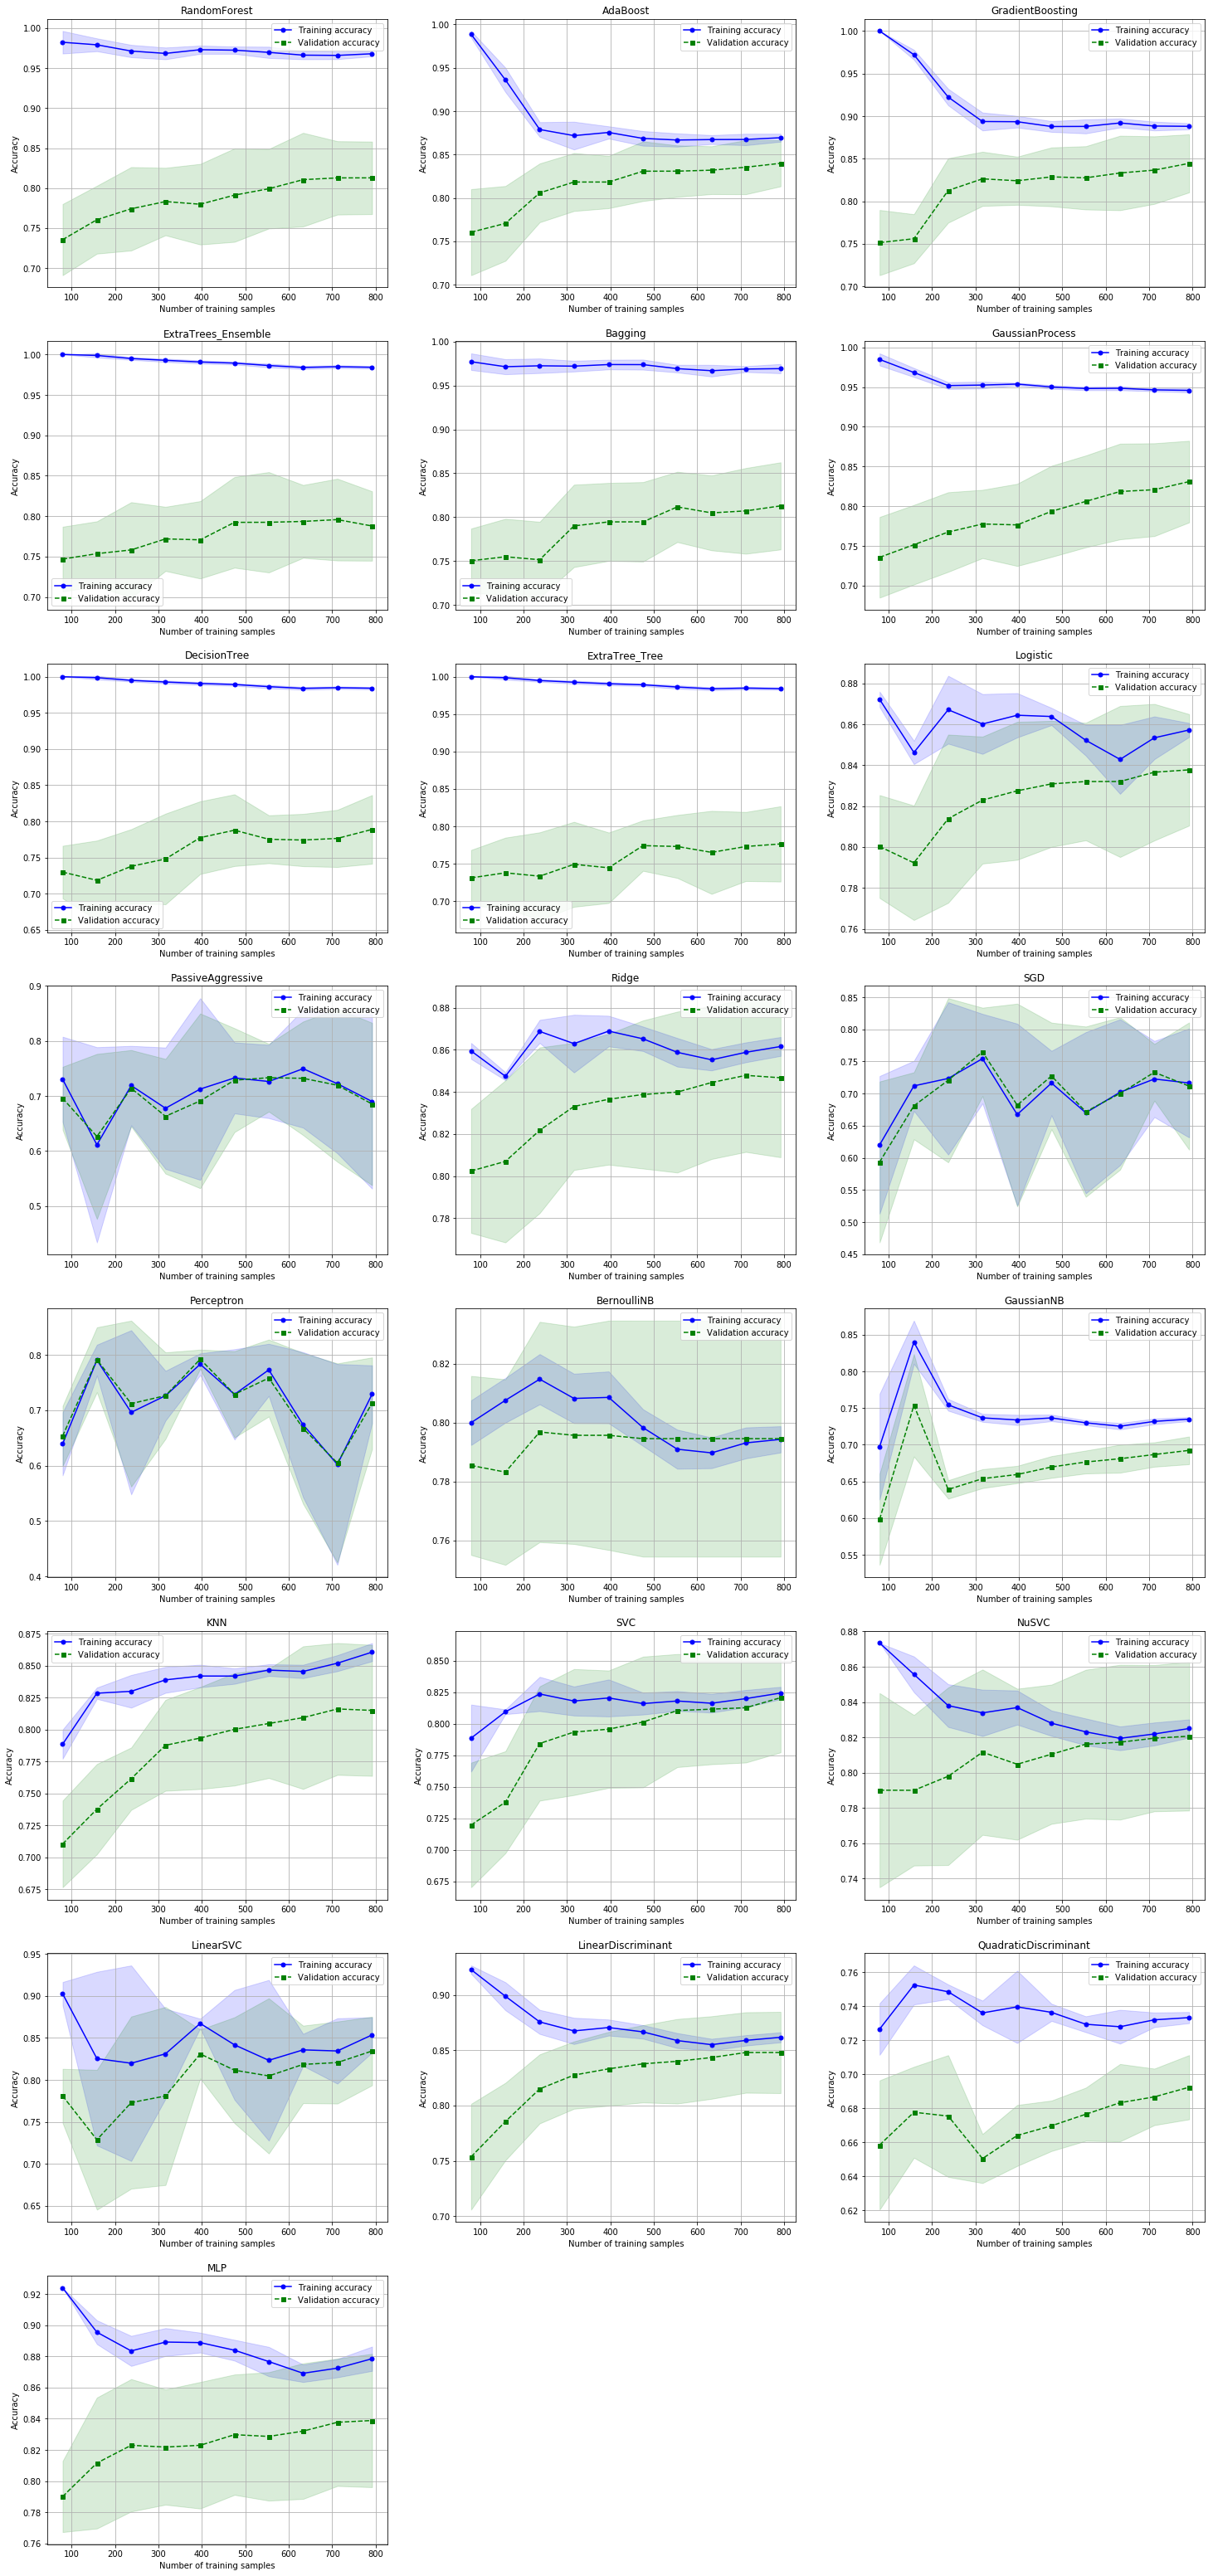

In [31]:
# Learning Curves
fcols = 3
frows = math.ceil(22/fcols)
plt.figure(figsize=(25,7*frows))

for i, [name, model] in enumerate(classifiers):
    train_sizes, train_scores, test_scores = \
        learning_curve(estimator=model, X=X, y=y, train_sizes=np.linspace(0.1, 1, 10), cv=10, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.subplot(frows,fcols,i+1)

    plt.plot(train_sizes, train_scores_mean,
             color='blue', marker='o',
             markersize=5, label='Training accuracy')

    plt.plot(train_sizes, test_scores_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='Validation accuracy')

    plt.fill_between(train_sizes,
                     train_scores_mean + train_scores_std,
                     train_scores_mean - train_scores_std,
                     alpha=0.15, color='blue')

    plt.fill_between(train_sizes,
                     test_scores_mean + test_scores_std,
                     test_scores_mean - test_scores_std,
                     alpha=0.15, color='green')

    plt.grid()
    plt.title(name)
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    

大部分的演算法表現都還不錯，大多有到80%以上的準確率。Learning顯示大部分還是不錯，但有些有overfitting的情況。
我選擇一些表現較優異的演算法來進行預測。

In [32]:
# Voting Classification
hard_vote_model = [
    ('Ridge', RidgeClassifierCV()),
    ('LinearDiscriminant', LinearDiscriminantAnalysis()),
    ('MLP', MLPClassifier()),
    ('GradientBoosting', GradientBoostingClassifier()),
    ('Logistic', LogisticRegressionCV()),
    ('LinearSVC', LinearSVC()),
    ('AdaBoost', AdaBoostClassifier()),
    ('NuSVC', NuSVC(probability=True)),
    ('SVC', SVC(probability=True)),
    ('RandomForest', RandomForestClassifier()),
    ]
# Hard Voting or Soft Voting?
vote_hard = VotingClassifier(estimators=hard_vote_model, voting='hard')
vote_hard_cv = cross_validate(vote_hard, X, y, cv=cv_split)

In [33]:
soft_vote_model = [
    ('LinearDiscriminant', LinearDiscriminantAnalysis()),
    ('MLP', MLPClassifier()),
    ('GradientBoosting', GradientBoostingClassifier()),
    ('Logistic', LogisticRegressionCV()),
    ('AdaBoost', AdaBoostClassifier()),
    ('NuSVC', NuSVC(probability=True)),
    ('SVC', SVC(probability=True)),
    ('RandomForest', RandomForestClassifier()),
    ]
vote_soft = VotingClassifier(estimators=soft_vote_model, voting='soft')
vote_soft_cv = cross_validate(vote_soft, X, y, cv=cv_split)

在分別執行Hard Voting與Soft Voting分類時，會碰到一些演算法無法使用Soft的情形，例如LinearSVC。這是因為比起LogisticRegression，LinearSVC
沒有辦法像LogisticRegression依樣產生一個機率估算值。因此我直接將其去除，然後進行比較。

In [35]:
Vote_Compare = pd.DataFrame({'Hard-Voting-Train':[vote_hard_cv['train_score'].mean()*100, vote_hard_cv['test_score'].mean()*100]
                            , 'Soft-Voting-Test':[vote_soft_cv['train_score'].mean()*100, vote_soft_cv['test_score'].mean()*100]
                                }, index=['Train', 'Test'])
Vote_Compare

,Hard-Voting-Train,Soft-Voting-Test
Train,86.875000,86.931818
Test,84.037736,83.924528


## Tuning  model

這裡開始是我最討厭的部分，因為根據硬體設備不同，調參的成本也會不同(玩到最後發現Kaggle根本就是在比硬體效能的)

In [36]:
grid_n_estimator = [10, 50, 100, 300, 500]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.001, .01, .03, .05, .1, .25, .5]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]

In [37]:
grid_param = [
    # Ridge
    [{
    }],
    # LinearDiscriminant
    [{
        'n_components':[10, 11, 12, 13, 15, 16, 17, 18, 19, 20]
    }],
    # MLP
    [{
        "alpha":  grid_ratio,
        'solver': ['lbfgs'],
        'max_iter': [1000],
        'random_state': grid_seed
    }],
    # GradientBoosting
    [{
        'learning_rate': grid_learn,
        'n_estimators': grid_n_estimator,
        'max_depth': grid_max_depth,
        'random_state': grid_seed
    }],
    # Logistic
    [{
        'fit_intercept': grid_bool,
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'random_state': grid_seed
    }],
    # LinearSVC
    [{
        'C': np.logspace(-3, 3, 100),
        'max_iter': [5000]
    }],
    # AdaBoost
    [{
        'n_estimators': grid_n_estimator,
        'learning_rate': grid_learn,
        'random_state': grid_seed
    }],
    # NuSVC
    [{
        'probability':[True] 
    }],
    # SVC
    [{
        'C': np.logspace(-3, 3, 100),
        'probability': [True] ,
        'random_state': grid_seed
    }],
    # RandomForest
    [{
        'n_estimators': grid_n_estimator, 
        'criterion': grid_criterion, 
        'max_depth': grid_max_depth,
        'oob_score': [True]
    }],
]

In [39]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [40]:
best_para_hard = []
start_time = timer(None)

for clf, para in zip(hard_vote_model, grid_param):
    best_search = model_selection.GridSearchCV(estimator=clf[1]
                                               , param_grid=para, cv=cv_split, scoring='roc_auc', n_jobs=-1)
    best_search.fit(X, y)
    best_para_hard.append([clf[0], best_search.best_estimator_])
timer(start_time)


 Time taken: 0 hours 19 minutes and 55.77 seconds.


In [41]:
# Hard Voting or Soft Voting?
vote_hard = VotingClassifier(estimators=best_para_hard, voting='hard')
vote_hard_cv = cross_validate(vote_hard, X, y, cv=cv_split)

In [42]:
best_para_soft = best_para_hard
best_para_soft.pop(0)
best_para_soft.pop(4)
vote_soft = VotingClassifier(estimators=best_para_soft, voting='soft')
vote_soft_cv = cross_validate(vote_soft, X, y, cv=cv_split)

In [43]:
Vote_Compare = pd.DataFrame({'Hard-Voting-Train':[vote_hard_cv['train_score'].mean()*100, vote_hard_cv['test_score'].mean()*100]
                            , 'Soft-Voting-Test':[vote_soft_cv['train_score'].mean()*100, vote_soft_cv['test_score'].mean()*100]
                                }, index=['Train', 'Test'])
Vote_Compare

,Hard-Voting-Train,Soft-Voting-Test
Train,86.647727,86.969697
Test,84.075472,83.962264


根據結果，調整過後的準確率到84%左右，WOOOOOOO!!!!!